In [14]:
from netCDF4 import Dataset
import netCDF4
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from datetime import datetime, timezone
import nc_time_axis
import xarray as xr
import math

atmos_epoch = datetime(1900, 1, 1, 0, 0, tzinfo=timezone.utc)

In [21]:
era5_geopotential = Dataset('../data/era5/geopotential_height_500hPa_era5_6hourly_z0001_daymean_2019_beginAdjust_1x1.nc', mode='r')
era5_labels = Dataset('../data/labels/GTD_1979-2019_JJAextd_8.nc', mode='r')

### load data
geopotential_xarray = xr.open_dataset(xr.backends.NetCDF4DataStore(era5_geopotential), decode_times=True)
labels_xarray = xr.open_dataset(xr.backends.NetCDF4DataStore(era5_labels), decode_times=True)
long = np.arange(-45, 55, 1)
lat = np.arange(30, 75, 1)

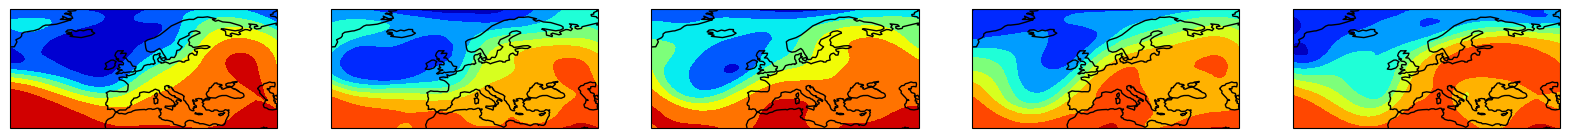

In [22]:
fig, axs = plt.subplots(nrows=1,ncols=5,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(20, 20))

axs = axs.flatten()


for i in range(5):
    axs[i].coastlines(resolution="110m",linewidth=1)
    cs = axs[i].contourf(long, lat, geopotential_xarray.z_0001[i], transform=ccrs.PlateCarree(),cmap=plt.cm.jet)

In [23]:
### a simplistic method to subtract the daily average values
def deseasonalization(ds):
    daily_climatology = ds.groupby('time.dayofyear').mean(dim='time')
    window_size=10
    ### make sure the circular nature of the data is recognized when taking the rolling mean
    daily_climatology_circular = xr.concat([daily_climatology.isel(dayofyear=slice(-window_size//2, None)),
                        daily_climatology,
                        daily_climatology.isel(dayofyear=slice(None, window_size//2))],
                        dim='dayofyear')
    # smooth the daily data for the climatology, because it is noisy
    daily_climatology_circular = daily_climatology_circular.rolling(dayofyear=10,center=True,min_periods=1).mean()
    daily_climatology = daily_climatology_circular.isel(dayofyear=slice(window_size//2,-window_size//2))
    # Subtract the daily climatology from the original data to get deseasonalized data
    ds_deseasonalized = ds - daily_climatology.sel(dayofyear=ds.time.dt.dayofyear)
    return ds_deseasonalized
    
### deaseasonalize and then divide by the respective standard deviation
ds_obs_anom = deseasonalization(geopotential_xarray)
ds_obs_anom.z_0001.data = ds_obs_anom.z_0001.data/np.std(ds_obs_anom.z_0001.data,axis=0)

In [24]:
# linear de-trending of co2 effect on geoptotential height

# def detrending(ds):
#     x = np.arange(len(ds.time))
#     coef = np.polyfit(x, ds.mean(), 1)
#     poly1d_fn = np.poly1d(coef)
#     return ds - poly1d_fn(x)

# ds_obs_anom_detrended = detrending(ds_obs_anom)

def detrending(ds):
    x = np.arange(len(ds.time))
    mean = np.mean(ds.z_0001.to_numpy(), axis=(1,2))
    coef = np.polyfit(x, mean, 1)
    poly1d_fn = np.poly1d(coef)
    
    poly_array = np.array([np.full((len(ds_obs_anom.z_0001[0]), len(ds_obs_anom.z_0001[0, 0])), poly1d_fn(x)) for x in range(len(ds.time))])
    detrended_ds = ds - poly_array
    return detrended_ds

# Assuming ds_obs_anom is an xarray dataset with a 'time' dimension
ds_obs_anom = detrending(ds_obs_anom)

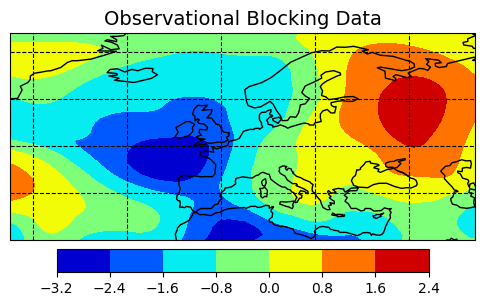

In [25]:
# plot observational data onto worldmap

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([-180, 180, 20, 90], crs=ccrs.PlateCarree())
ax.coastlines(resolution="110m",linewidth=1)
ax.gridlines(linestyle='--',color='black')

plt.contourf(long, lat, ds_obs_anom.z_0001[0], transform=ccrs.PlateCarree(),cmap=plt.cm.jet)
plt.title('Observational Blocking Data', size=14)
cb = plt.colorbar(ax=ax, orientation="horizontal", pad=0.02, aspect=16, shrink=0.8)
cb.ax.tick_params(labelsize=10)

In [29]:
import os

try:
    os.remove('../data/era5/geopotential_height_500hPa_era5_6hourly_z0001_daymean_2019_beginAdjust_1x1_final.nc')
except:
    pass

ncfile = Dataset('../data/era5/geopotential_height_500hPa_era5_6hourly_z0001_daymean_2019_beginAdjust_1x1_final.nc', mode='w', format='NETCDF4')

ncfile.set_fill_off()

ncfile.createDimension("time", None)
ncfile.createDimension("longitude", 100)
ncfile.createDimension("latitude", 45)
ncfile.createDimension("day_range", 5)

variable = ncfile.createVariable("time", "i4", ("time",))
variable.setncatts({k: era5_geopotential.variables["time"].getncattr(k) for k in era5_geopotential.variables["time"].ncattrs()})
ncfile.createVariable("day_range", "i4", ("day_range",))
variable = ncfile.createVariable("longitude", "f4", ("longitude",))
variable.setncatts({k: era5_geopotential.variables["lon"].getncattr(k) for k in era5_geopotential.variables["lon"].ncattrs()})
variable = ncfile.createVariable("latitude", "f4", ("latitude",))
variable.setncatts({k: era5_geopotential.variables["lat"].getncattr(k) for k in era5_geopotential.variables["lat"].ncattrs()})
variable = ncfile.createVariable("z_0001", "f4", ("time", "day_range", "latitude", "longitude"))
# variable.setncatts({k: era5_geopotential.variables["z_0001"].getncattr(k) for k in era5_geopotential.variables["z_0001"].ncattrs()})

len_time = ds_obs_anom.time.shape[0]
len_lat = ds_obs_anom.lat.shape[0]
len_long = ds_obs_anom.lon.shape[0]

result = np.zeros((len_time, 5, len_lat, len_long))

temp_zg = ds_obs_anom.z_0001.data
for i in range(len_time):
    if (i % 50 == 0): print("working on " + str(i) + " of " + str(len_time))
    if len(temp_zg) < 5:
        ncfile.variables["z_0001"][i] = np.array([temp_zg[0], temp_zg[0], temp_zg[0], temp_zg[0], temp_zg[0]])
    else:
        ncfile.variables["z_0001"][i] = np.array([temp_zg[0], temp_zg[0 + 1], temp_zg[0 + 2], temp_zg[0 + 3], temp_zg[0 + 4]])
    temp_zg = temp_zg[1:]
print(result.shape)

# decode times back to hours since 1900-01-01 00:00:00

ncfile.variables["time"][:] = era5_geopotential.variables["time"][:]
ncfile.variables["longitude"][:] = ds_obs_anom.lon.data[:]
ncfile.variables["latitude"][:] = ds_obs_anom.lat.data[:]
ncfile.variables["day_range"][:] = [0, 1, 2, 3, 4]

ncfile.close()

working on 0 of 4018
working on 50 of 4018
working on 100 of 4018
working on 150 of 4018
working on 200 of 4018
working on 250 of 4018
working on 300 of 4018
working on 350 of 4018
working on 400 of 4018
working on 450 of 4018
working on 500 of 4018
working on 550 of 4018
working on 600 of 4018
working on 650 of 4018
working on 700 of 4018
working on 750 of 4018
working on 800 of 4018
working on 850 of 4018
working on 900 of 4018
working on 950 of 4018
working on 1000 of 4018
working on 1050 of 4018
working on 1100 of 4018
working on 1150 of 4018
working on 1200 of 4018
working on 1250 of 4018
working on 1300 of 4018
working on 1350 of 4018
working on 1400 of 4018
working on 1450 of 4018
working on 1500 of 4018
working on 1550 of 4018
working on 1600 of 4018
working on 1650 of 4018
working on 1700 of 4018
working on 1750 of 4018
working on 1800 of 4018
working on 1850 of 4018
working on 1900 of 4018
working on 1950 of 4018
working on 2000 of 4018
working on 2050 of 4018
working on 2100

AttributeError: NetCDF: Attribute not found

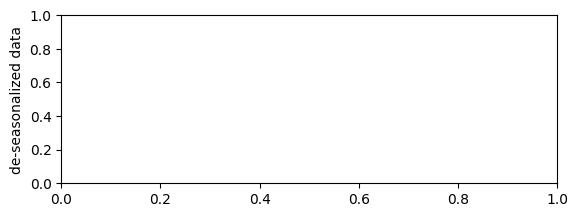

In [8]:
data = Dataset('../data/geopotential_height_500hPa_era5_6hourly_z0001_daymean_final.nc', mode='r')

plt.subplot(2, 1, 2)
plt.ylabel("de-seasonalized data")
time = netCDF4.num2date(data.variables["time"][:], data.variables["time"].units, data.variables["time"].calendar)
plt.plot(time[::10], np.mean(data.variables["z_0001"][::10], axis=(1, 2)))
plt.show()